#Installing and Importing libraries

Need mount your Google Drive folder, make sure you change the directory to the one where you paste the entire repository

In [1]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/mydir')

# Define the path for the folder where you want to clone the repository
folder_path = '/content/mydir/MyDrive/Quantum-Dynamics-Tutorial'

# Create the folder if it doesn't already exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Created folder: {folder_path}")

# Change the current working directory to the folder where you want to clone the repository
os.chdir(folder_path)

# Clone the GitHub Repository into the specified folder
#!git clone https://github.com/XiaohanDan97/CCI_PartIII_GQME .

Drive already mounted at /content/mydir; to attempt to forcibly remount, call drive.mount("/content/mydir", force_remount=True).


In [2]:
import numpy as np
import time

#parameters in the simulation
import QFlux.GQME.params as pa
#read and write functions
import QFlux.GQME.readwrite as wr

import matplotlib.pyplot as plt

/content/mydir/MyDrive
SPIN-BOSON Model parameter
        epsilon = 1
             xi = 0.1
        omega_c = 2
      omega_max = 10
     time steps = 500
             DT = 0.00600331998021117
     final time = 3.001659990105585
          DOF_E = 2
          DOF_N = 50


#Using TT-TFD to simulate Spin-Boson Model Dynamics

In [3]:
!pip install mpsqd

In [4]:
from QFlux.GQME.dynamics_GQME import DynamicsGQME

#============setup the Hamiltonian and initial state for Spin-Boson Model
Hsys = pa.EPSILON*pa.Z + pa.GAMMA_DA*pa.X
rho0 = np.zeros((pa.DOF_E,pa.DOF_E),dtype=np.complex128)
rho0[0,0] = 1.0

#Create the Spin-Boson model (SBM)
SBM = DynamicsGQME(pa.DOF_E,Hsys,rho0)
SBM.setup_timestep(pa.DT, pa.TIME_STEPS)

In [5]:
#The expected waiting time for the TT-TFD calculation is relatively long.
#To save time, the results are already pre-computed and saved.
#The following code would still run normally without running TT-TFD (Is_run_dynamics = False).
#To run the dynamics through TT-TFD, change Is_run_dynamics = True

Is_run_dynamics = False

In [6]:
if Is_run_dynamics:
  import QFlux.GQME.tt_tfd as tfd

  #RDO: reduced density operator, contain the information of population and coherence
  #initial_state=0: initial at Donor state
  t, RDO_arr = tfd.tt_tfd(initial_state=0, show_steptime=True, update_type='rk4')

  #TT-TFD is time consuming, after running it once, you can read it from the file without running it again
  #output to the file
  wr.output_operator_array(t, RDO_arr, "QFlux/GQME/TTTFD_Output/TFDSigma_")

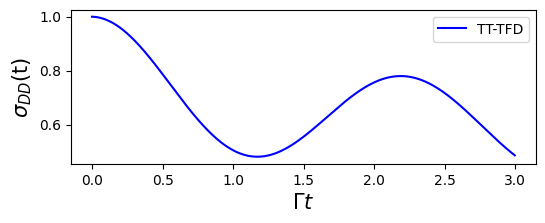

In [7]:
#read and plot
t, RDO_arr = wr.read_operator_array(pa.TIME_STEPS,"QFlux/GQME/TTTFD_Output/TFDSigma_")
plt.figure(figsize=(6,2))
plt.plot(t, RDO_arr[:,0].real,'b-', label='TT-TFD')
plt.xlabel('$\Gamma t$',fontsize=15)
plt.ylabel('$\sigma_{DD}$(t)',fontsize=15)
plt.legend()

#Using GQME to simulate Spin-Boson Model dynamics

##The projected Liouvillian

In [8]:
LN0 = np.zeros((pa.DOF_E_SQ, pa.DOF_E_SQ))
LN0[0][1] = LN0[1][0] = LN0[2][3] = LN0[3][2] = -pa.GAMMA_DA
LN0[0][2] = LN0[2][0] = LN0[1][3] = LN0[3][1] = pa.GAMMA_DA
LN0[1][1] = 2. * pa.EPSILON
LN0[2][2] = -2. * pa.EPSILON

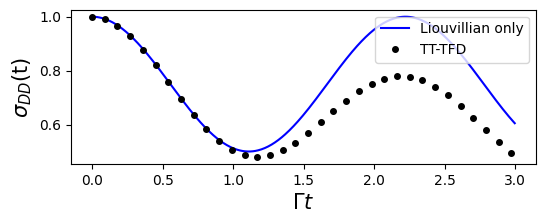

In [9]:
import scipy.linalg as LA
sigma_liou = np.zeros((pa.TIME_STEPS, pa.DOF_E_SQ), dtype=np.complex128)
time_arr = np.linspace(0,(pa.TIME_STEPS-1)*pa.DT,pa.TIME_STEPS)
sigma_liou[0] = np.array([1.0,0,0,0],dtype=np.complex128)
for i in range(1,pa.TIME_STEPS):
  sigma_liou[i] = LA.expm(-1j*LN0*pa.DT)@sigma_liou[i-1]

#read TT-TFD result and plot to compare
timeVec, sigma_tt_tfd = wr.read_operator_array(pa.TIME_STEPS,"QFlux/GQME/TTTFD_Output/TFDSigma_")
plt.figure(figsize=(6,2))
plt.plot(time_arr, sigma_liou[:,0].real,'b-', label='Liouvillian only')
plt.plot(timeVec,  sigma_tt_tfd[:,0].real,'ko', markersize=4,markevery=15, label='TT-TFD')
plt.xlabel('$\Gamma t$',fontsize=15)
plt.ylabel('$\sigma_{DD}$(t)',fontsize=15)
plt.legend(loc = 'upper right')

## Calculating the Memory Kernel

### The Projection-Free Inputs

In [10]:
def cal_U_tt_tfd():

    U = np.zeros((pa.TIME_STEPS, pa.DOF_E_SQ, pa.DOF_E_SQ), dtype=np.complex128)

    # tt-tfd with initial state 0,1,2,3
    # initial state |0> means donor state |D>, |3> means acceptor state |A>
    # |1> is (|D> + |A>)/sqrt(2), |2> is (|D> + i|A>)/sqrt(2)
    print('========calculate the propagator, starting from 0 state========')
    t,U[:,:,0] = tfd.tt_tfd(0)
    print('========calculate the propagator, starting from 1 state========')
    t,U[:,:,1] = tfd.tt_tfd(1)
    print('========calculate the propagator, starting from 2 state========')
    t,U[:,:,2] = tfd.tt_tfd(2)
    print('========calculate the propagator, starting from 3 state========')
    t,U[:,:,3] = tfd.tt_tfd(3)
    print('========calculate the propagator done========')

    U_final = U.copy()

    # the coherence elements that start at initial state |D><A| and |A><D|
    # is the linear combination of above U results
    # |D><A| = |1><1| + i * |2><2| - 1/2 * (1 + i) * (|0><0| + |3><3|)
    U_final[:,:,1] = U[:,:,1] + 1.j * U[:,:,2] - 0.5 * (1. + 1.j) * (U[:,:,0] + U[:,:,3])

    # |A><D| = |1><1| - i * |2><2| - 1/2 * (1 - i) * (|0><0| + |3><3|)
    U_final[:,:,2] = U[:,:,1] - 1.j * U[:,:,2] - 0.5 * (1. - 1.j) * (U[:,:,0] + U[:,:,3])

    return t,U_final

In [11]:
#The line below calculates all U elements with TT-TFD. The expected waiting time is 40 minutes on Google Colab.
#To save time, the results are already pre-computed and saved, and Is_run_dynamics is therefore set as False.
#The following code would still run normally. Please set Is_run_dynamics = True if one wishes to perform these calculations.
if Is_run_dynamics:
    t,Gt = cal_U_tt_tfd()

    #output the propagator
    wr.output_superoper_array(t,Gt,"QFlux/GQME/U_Output/U_")

In [12]:
def cal_F():
    #read the propagator data from files
    timeVec,U = wr.read_superoper_array(pa.TIME_STEPS,"QFlux/GQME/U_Output/U_")

    F = np.zeros((pa.TIME_STEPS, pa.DOF_E_SQ, pa.DOF_E_SQ), dtype=np.complex128)
    Fdot = np.zeros((pa.TIME_STEPS, pa.DOF_E_SQ, pa.DOF_E_SQ), dtype=np.complex128)

    for j in range(pa.DOF_E_SQ):
        for k in range(pa.DOF_E_SQ):
            # extracts real and imag parts of U element
            Ureal = U[:,j,k].copy().real
            Uimag = U[:,j,k].copy().imag

            # F = i * d/dt U so Re[F] = -1 * d/dt Im[U] and Im[F] = d/dt Re[U]
            Freal = -1. * np.gradient(Uimag.flatten(), pa.DT, edge_order = 2)
            Fimag = np.gradient(Ureal.flatten(), pa.DT, edge_order = 2)

            # Fdot = d/dt F so Re[Fdot] = d/dt Re[F] and Im[Fdot] = d/dt Im[F]
            Fdotreal = np.gradient(Freal, pa.DT)
            Fdotimag = np.gradient(Fimag, pa.DT)

            F[:,j,k] = Freal[:] + 1.j * Fimag[:]
            Fdot[:,j,k] = Fdotreal[:] + 1.j * Fdotimag[:]

    return timeVec,F,Fdot

In [13]:
timeVec,F,Fdot = cal_F()

###volterra scheme: calculating the Memory kernel and output to the file

In [14]:
linearTerm = 1.j * Fdot.copy() # first term of the linear part
for l in range(pa.TIME_STEPS):
    # subtracts second term of linear part
    linearTerm[l,:,:] -= 1./pa.HBAR * F[l,:,:] @ LN0

In [15]:
def CalculateIntegral(F, linearTerm, prevKernel, kernel):

    # time step loop starts at 1 because K is equal to linear part at t = 0
    for n in range(1, pa.TIME_STEPS):
        kernel[n,:,:] = 0.

        # f(a) and f(b) terms
        kernel[n,:,:] += 0.5 * pa.DT * F[n,:,:] @ kernel[0,:,:]
        kernel[n,:,:] += 0.5 * pa.DT * F[0,:,:] @ prevKernel[n,:,:]

        # sum of f(a + kh) term
        for c in range(1, n):
            # since a new (supposed-to-be-better) guess for the
            # kernel has been calculated for previous time steps,
            # can use it rather than prevKernel
            kernel[n,:,:] += pa.DT * F[n - c,:,:] @ kernel[c,:,:]

        # multiplies by i and adds the linear part
        kernel[n,:,:] = 1.j * kernel[n,:,:] + linearTerm[n,:,:]

    return kernel

In [16]:
START_TIME = time.time() # starts timing
# sets initial guess to the linear part
prevKernel = linearTerm.copy()
kernel = linearTerm.copy()

# loop for iterations
for numIter in range(1, pa.MAX_ITERS + 1):

    iterStartTime = time.time() # starts timing of iteration
    print("Iteration:", numIter)

    # calculates kernel using prevKernel and trapezoidal rule
    kernel = CalculateIntegral(F, linearTerm, prevKernel, kernel)

    numConv = 0 # parameter used to check convergence of entire kernel
    for i in range(pa.DOF_E_SQ):
        for j in range(pa.DOF_E_SQ):
            for n in range(pa.TIME_STEPS):
                # if matrix element and time step of kernel is converged, adds 1
                if abs(kernel[n][i][j] - prevKernel[n][i][j]) <= pa.CONVERGENCE_PARAM:
                    numConv += 1

                # if at max iters, prints which elements and time steps did not
                # converge and prevKernel and kernel values
                elif numIter == pa.MAX_ITERS:
                    print("\tK time step and matrix element that didn't converge: %s, %s%s"%(n,i,j))

    print("\tIteration time:", time.time() - iterStartTime)

    # enters if all times steps and matrix elements of kernel converged
    if numConv == pa.TIME_STEPS * pa.DOF_E_SQ * pa.DOF_E_SQ:
        # prints number of iterations and time necessary for convergence
        print("Number of Iterations:", numIter, "\tVolterra time:", time.time() - START_TIME)

        # prints memory kernel to files
        wr.output_superoper_array(timeVec,kernel,"QFlux/GQME/K_Output/K_")

        break # exits the iteration loop

    # if not converged, stores kernel as prevKernel, zeros the kernel, and then
    # sets kernel at t = 0 to linear part
    prevKernel = kernel.copy()
    kernel = linearTerm.copy()

    # if max iters reached, prints lack of convergence
    if numIter == pa.MAX_ITERS:
        print("\tERROR: Did not converge for %s iterations"%pa.MAX_ITERS)
        print("\tVolterra time:", print(time.time() - START_TIME))

Iteration: 1
	Iteration time: 1.9061214923858643
Iteration: 2
	Iteration time: 1.880920648574829
Iteration: 3
	Iteration time: 3.2133710384368896
Iteration: 4
	Iteration time: 3.121506690979004
Iteration: 5
	Iteration time: 2.67923641204834
Iteration: 6
	Iteration time: 2.0692851543426514
Iteration: 7
	Iteration time: 2.2968568801879883
Iteration: 8
	Iteration time: 1.3086392879486084
Number of Iterations: 8 	Volterra time: 18.496930360794067


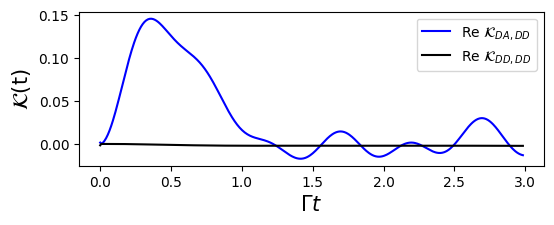

In [17]:
#plot the kernel without the last two boundary points that have numerical errors
plt.figure(figsize=(6,2))
plt.plot(timeVec[:-2], kernel[:-2,1,0].real,'b-', label='Re $\mathcal{K}_{DA,DD}$')
plt.plot(timeVec[:-2], kernel[:-2,0,0].real,'k-', label='Re $\mathcal{K}_{DD,DD}$')
plt.xlabel('$\Gamma t$',fontsize=15)
plt.ylabel('$\mathcal{K}$(t)',fontsize=15)
plt.legend(loc = 'upper right')

##Propagate the GQME

In [18]:
def PropagateRK4(currentTime, memTime, kernel,
                 sigma_hold, sigma):

    f_0 = Calculatef(currentTime, memTime,
                     kernel, sigma, sigma_hold)

    k_1 = sigma_hold + pa.DT * f_0 / 2.
    f_1 = Calculatef(currentTime + pa.DT / 2., memTime,
                     kernel, sigma, k_1)

    k_2 = sigma_hold + pa.DT * f_1 /2.
    f_2 = Calculatef(currentTime + pa.DT / 2., memTime,
                     kernel, sigma, k_2)

    k_3 = sigma_hold + pa.DT * f_2
    f_3 = Calculatef(currentTime + pa.DT, memTime,
                     kernel, sigma, k_3)

    sigma_hold += pa.DT / 6. * (f_0 + 2. * f_1 + 2. * f_2 + f_3)

    return sigma_hold


In [19]:
def Calculatef(currentTime, memTime, kernel, sigma_array, kVec):
    global LN0

    memTimeSteps = int(memTime / pa.DT)
    currentTimeStep = int(currentTime / pa.DT)

    f_t = np.zeros(kVec.shape, dtype=np.complex128)

    f_t -= 1.j / pa.HBAR * LN0 @ kVec

    limit = memTimeSteps
    if currentTimeStep < (memTimeSteps - 1):
        limit = currentTimeStep
    for l in range(limit):
        f_t -= pa.DT * kernel[l,:,:] @ sigma_array[currentTimeStep - l]

    return f_t


In [20]:
#read the memory kernel
timeVec,kernel = wr.read_superoper_array(pa.TIME_STEPS,"QFlux/GQME/K_Output/K_")

# array for reduced density matrix elements
sigma = np.zeros((pa.TIME_STEPS, pa.DOF_E_SQ), dtype=np.complex128)
# array to hold copy of sigma
sigma_hold = np.zeros(pa.DOF_E_SQ, dtype = np.complex128)

# sets the initial state at Donor State
sigma[0,0] = 1.
sigma_hold[0] = 1.

# loop to propagate sigma
print(">>> Starting GQME propagation, memory time =", pa.MEM_TIME)
for l in range(pa.TIME_STEPS - 1): # it propagates to the final time step
    if l%100==0: print(l)
    currentTime = l * pa.DT

    sigma_hold = PropagateRK4(currentTime, pa.MEM_TIME, kernel, sigma_hold, sigma)

    sigma[l + 1] = sigma_hold.copy()

# prints sigma to files
wr.output_operator_array(timeVec, sigma, "QFlux/GQME/GQME_Output/Sigma_")

>>> Starting GQME propagation, memory time = 3.001659990105585
0
100
200
300
400


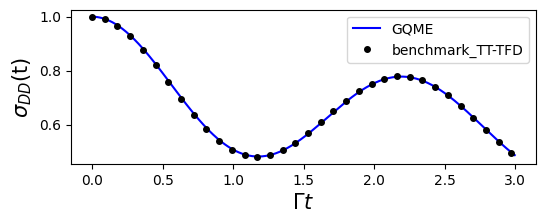

In [21]:
# Read the reference data and plot
timeVec, sigma_tt_tfd = wr.read_operator_array(pa.TIME_STEPS,"QFlux/GQME/TTTFD_Output/TFDSigma_")
timeVec, sigma = wr.read_operator_array(pa.TIME_STEPS,"QFlux/GQME/GQME_Output/Sigma_")

plt.figure(figsize=(6,2))
plt.plot(timeVec, sigma[:,0].real,'b-', label='GQME')
plt.plot(timeVec, sigma_tt_tfd[:,0].real ,'ko', markersize=4, markevery=15, label='benchmark_TT-TFD')
plt.xlabel('$\Gamma t$',fontsize=15)
plt.ylabel('$\sigma_{DD}$(t)',fontsize=15)
plt.legend()

# Quantum Algorithms of GQME based on Dilation

## Solving the GQME to get the propagator

In [ ]:
#read the memory kernel
timeVec,kernel = wr.read_superoper_array(pa.TIME_STEPS,"QFlux/GQME/K_Output/K_")

# array for Propagator superoperator elements
G_prop = np.zeros((pa.TIME_STEPS, pa.DOF_E_SQ, pa.DOF_E_SQ), dtype=np.complex128)

#time 0 propagator: identity superoperator
G_prop[0] = np.eye(pa.DOF_E_SQ)
#array to hold copy of G propagator
G_prop_hold = np.eye((pa.DOF_E_SQ), dtype=np.complex128)

# loop to propagate G_prop using GQME
print(">>> Starting GQME propagation, memory time =", pa.MEM_TIME)
for l in range(pa.TIME_STEPS - 1): # it propagates to the final time step
    if l%100==0: print(l)
    currentTime = l * pa.DT

    G_prop_hold = PropagateRK4(currentTime, pa.MEM_TIME, kernel, G_prop_hold, G_prop)

    G_prop[l + 1] = G_prop_hold.copy()

## Dilation of the non-unitary propagator

In [ ]:
def dilate(array):

  # Normalization factor of 1.1 to ensure contraction
  norm = LA.norm(array,2)*1.1
  array_new = array/norm

  ident = np.eye(array.shape[0])

  # Calculate the conjugate transpose of the G propagator
  fcon = (array_new.conjugate()).T

  # Calculate the defect matrix for dilation
  fdef = LA.sqrtm(ident - np.dot(fcon, array_new))

  # Calculate the defect matrix for the conjugate of the G propagator
  fcondef = LA.sqrtm(ident - np.dot(array_new, fcon))

  # Dilate the G propagator to create a unitary operator
  array_dilated = np.block([[array_new, fcondef], [fdef, -fcon]])

  return array_dilated, norm

## Quantum Simulation of GQME with QASM Simulator

In [ ]:
!pip install qiskit==1.2.0
!pip install qiskit_aer==0.15.0

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Operator

In [ ]:
# Create a dictionary to store the measurement results
result = {'000': 0, '001': 0, '010': 0, '011': 0, '100': 0, '101': 0, '110': 0, '111': 0}

# Create lists to store the population for the acceptor and donor states
pop_accept = []
pop_donor = []

# initial state in the dilated space
rho0_dilated = np.concatenate((np.array([1 + 0j, 0, 0, 0]),np.zeros(pa.DOF_E_SQ)))

for i in range(pa.TIME_STEPS):

    qr = QuantumRegister(3)  # Create a quantum register with 3 qubits
    cr = ClassicalRegister(3)  # Create a classical register to store measurement results
    qc = QuantumCircuit(qr, cr)  # Combine the quantum and classical registers to create the quantum circuit

    # Initialize the quantum circuit with the initial state
    qc.initialize(rho0_dilated, qr)

    # Dilated propagator
    U_G, norm = dilate(G_prop[i])

    # Create a custom unitary operator with the dilated propagator
    U_G_op = Operator(U_G)

    # Apply the unitary operator to the quantum circuit's qubits
    qc.unitary(U_G_op, qr)
    # Measure the qubits and store the results in the classical register
    qc.measure(qr, cr)

    #Run the Simulation and Plot the Results
    simulator = QasmSimulator()
    shots = 2000  # Number of shots
    job = simulator.run(qc,shots=shots)
    counts = job.result().get_counts(qc)

    # Update the result dictionary
    for x in counts:
        result[x] = counts[x]

    # Calculate the populations of donor and acceptor states from measurement probabilities
    pop_d = np.sqrt(result['000'] / shots) * norm  # Multiply by the normalization factor
    pop_a = np.sqrt(result['011'] / shots) * norm  # Multiply by the normalization factor

    pop_donor.append(pop_d)  # Stacking the population for the donor state
    pop_accept.append(pop_a)  # Stacking the population for the acceptor state

In [ ]:
# Read the exact TT-TFD results
timeVec, sigma_tt_tfd = wr.read_operator_array(pa.TIME_STEPS,"QFlux/GQME/TTTFD_Output/TFDSigma_")
# Plot the population of the donor and acceptor states
plt.figure(figsize=(6,2))
plt.plot(timeVec, pop_donor, 'r-', label="quantum simulation")
plt.plot(timeVec, sigma_tt_tfd[:,0].real ,'ko', markersize=4, markevery=15, label='benchmark_TT-TFD')
plt.xlabel('$\Gamma t$',fontsize=15)
plt.ylabel('$\sigma_{DD}$(t)',fontsize=15)
plt.legend(loc = 'upper right')